In [2]:
import pandas as pd
import pdfkit
import matplotlib.pyplot as plt
from io import BytesIO
import binascii
import smtplib
from email import encoders
from email.mime.text import MIMEText
from email.mime.base import MIMEBase
from email.mime.multipart import MIMEMultipart

In [ ]:
'''Задание: автоматические отчеты
Соберите отчет по результатам ЕГЭ в 2018-2019 году, используя данные
https://video.ittensive.com/python-advanced/data-9722-2019-10-14.utf.csv
и отправьте его в HTML формате по адресу support@ittensive.com, используя только Python.
В отчете должно быть:
общее число отличников (учеников, получивших более 220 баллов по ЕГЭ в Москве),
распределение отличников по округам Москвы,
название школы с лучшими результатами по ЕГЭ в Москве.
Диаграмма распределения должна быть вставлена в HTML через data:URI формат (в base64-кодировке).
Дополнительно: приложите к отчету PDF документ того же содержания (дублирующий письмо).data_ege["PASSES_OVER_220"].groupby("AdmArea").sum().plot.pie(ax=area, label="",fontsize=6) # график'''

In [3]:
#https://video.ittensive.com/python-advanced/data-9722-2019-10-14.utf.csv

data_ege = pd.read_csv("http://video.ittensive.com/python-advanced/data-9722-2019-10-14.utf.csv", delimiter=";")
data_ege = data_ege.dropna(axis=1) #убираем столец без данных NaN
data_ege["AdmArea"] = data_ege["AdmArea"].apply(lambda x:x.split(" ")[0]).astype("category") # берём первое слово из названия округа
data_ege = data_ege.set_index(["YEAR"])
data_ege = data_ege.loc["2018-2019"].reset_index() # выбираем нужные учебный год,
data = data_ege.sort_values("PASSES_OVER_220", ascending=False).head(1)
print (data.head(1))

          YEAR    ID                                           EDU_NAME  \
239  2018-2019  9973  Федеральное государственное автономное образов...   

      global_id      AdmArea         District  PASSES_OVER_220  \
239  1011905309  Центральный  Басманный район              626   

     PASSER_UNDER_160  
239               682  


C:\Users\Ferm4\AppData\Local\Temp\ipykernel_4708\2725432247.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_a = data_a.groupby("AdmArea").sum()["PASSES_OVER_220"].sort_values(ascending=False)


23368


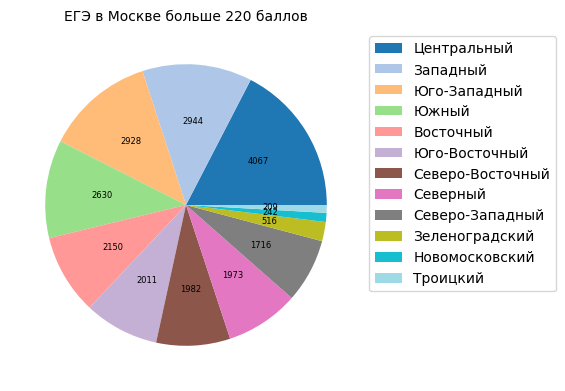

In [4]:


fig = plt.figure(figsize=(8,4))
area = fig.add_subplot(1, 1, 1)
data_a = data_ege.set_index(["AdmArea"])
data_a = data_a.groupby("AdmArea").sum()["PASSES_OVER_220"].sort_values(ascending=False)
sum_dat = data_a.sum()
print (sum_dat)
data_a.plot.pie(ax = area,  labels=[""]*len(data_a), label="", fontsize=6,
                                     cmap="tab20", autopct=lambda x:int(round(sum_dat * x/100)))
plt.legend(data_a.index, bbox_to_anchor=(1,1,0.1,0), fontsize=10)
area.set_title("ЕГЭ в Москве больше 220 баллов", fontsize=10)
plt.subplots_adjust(bottom=0, left=-0.4) #сдвигаем графиг к левому краю
img = BytesIO()
plt.savefig('Ege.png') # сохраняем график ввиде рисунка
plt.savefig(img)
img = 'data:image/png;base64,' + binascii.b2a_base64(img.getvalue(),
                            newline=False).decode("UTF-8")
#print (data_ege.head(3))

In [78]:
print (data.head(0))

Empty DataFrame
Columns: [YEAR, ID, EDU_NAME, global_id, AdmArea, District, PASSES_OVER_220, PASSER_UNDER_160]
Index: []


In [5]:
from jinja2 import Template
html = '''<html>
<head>
    <title>Результаты ЕГЭ Москвы: отличники</title>
    <meta charset="utf-8"/>
</head>
<body>
    <h1>Результаты ЕГЭ Москвы: отличники в 2018-2019 году</h1>
    <p>Всего: ''' + str(sum_dat) + '''</p>
    <img src="''' + img + '''" alt="Отличники по округам"/>
     <p>Лучшая школа: ''' + str(data["EDU_NAME"].values[0]) + '''</p>
     <p>Округ: ''' + str(data["AdmArea"].values[0]) + ''', '''+ str(data["District"].values[0]) +'''</p>
         
</body>
</html>'''



config = pdfkit.configuration(wkhtmltopdf='D:/wkhtmltopdf/bin/wkhtmltopdf.exe')
options = {
    'page-size': 'A4',
    'header-right': '[page]'
}
pdfkit.from_string(html, 'Moscow_EGE.pdf',
                  configuration=config, options = options)

True

letter = MIMEMultipart()
letter["From"] = "Черёмин Михаил"
letter["Subject"] = " ЕГЭ по Москве"
letter["Content-Type"] = "text/html; charset=utf-8"
letter["To"] = "support@ittensive.com"
letter.attach(MIMEText(html, "html"))
attachement = MIMEBase("application", "pdf")
attachement.set_payload(open("Moscow_EGE.pdf", "rb").read())
attachement.add_header("Content-Disposition",
                      'attachement; filename="Moscow_EGE.pdf"')
encoders.encode_base64(attachement)
letter.attach(attachement)
user = "chmg@rambler.ru"
password = "2wsedr5-"
server = smtplib.SMTP("smtp.rambler.ru", 2525)
server.login(user, password)
server.sendmail("n@ittensive.com",
               "support@ittensive.com",
               letter.as_string())

In [8]:
letter = MIMEMultipart()
letter["From"] = "Черёмин Михаил" 
letter["Subject"] = " ЕГЭ по Москве" 
letter["Content-Type"] = "text/html; charset=utf-8" 
letter["To"] = "chmg@rambler.ru" 
letter.attach(MIMEText(html, "html")) 
attachement = MIMEBase("application", "pdf") 
attachement.set_payload(open("Moscow_EGE.pdf", "rb").read()) 
attachement.add_header("Content-Disposition", 'attachement; filename="Moscow_EGE.pdf"') 
encoders.encode_base64(attachement) 
letter.attach(attachement) 
#user = "XXX"
#password = "XXX"
server = smtplib.SMTP_SSL("smtp.mail.ru", 465)
server.login(user, password) 
server.sendmail("stud_ipk@mail.ru",
                "stud_ipk@mail.ru",
                letter.as_string())
server.quit()

SMTPDataError: (550, b'your mailer sends invalid headers')